
# Curve Fitting & Linear Regression Demo

This notebook demonstrates:

- Loading and preparing data with Pandas & NumPy  
- Visualizing data with Matplotlib  
- Fitting models with SciPy's `curve_fit`  
- Re-deriving linear and quadratic fits via linear algebra (normal equations)  
- Fitting power-law and exponential models via log transforms  

We'll use a synthetic beverage dataset with:

- `Drink` — name of the drink  
- `oz` — serving size in ounces  
- `calories` — total calories per serving  

We analyze **calories per ounce** as a function of serving size.


## 1. Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.optimize import curve_fit

# Plot style (optional)
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 120

## 2. Create and Inspect the Dataset

We create a synthetic dataset of beverages with:

- 150 drinks  
- Serving size `oz` between 4 and 20  
- A nonlinear relationship between serving size and calories per ounce  
- Random noise, so curve fitting is non-trivial


In [ ]:
# Reproducibility
np.random.seed(42)

N = 150
oz = np.random.uniform(4, 20, size=N)  # serving size in ounces

# Underlying "true" relationship for calories per ounce (nonlinear)
true_cal_per_oz = 5 + 0.3 * oz + 0.02 * oz**2

# Add noise and keep values positive
noise = np.random.normal(0, 8, size=N)
cal_per_oz = np.clip(true_cal_per_oz + noise, a_min=10, a_max=None)

# Total calories per serving
calories = cal_per_oz * oz

# Build DataFrame
drinks = [f"Drink_{i+1}" for i in range(N)]
df = pd.DataFrame({
    "Drink": drinks,
    "oz": oz,
    "calories": calories
})

df.head()

,Drink,oz,calories
0,Drink_1,9.992642,99.926419
1,Drink_2,19.211429,394.936787
2,Drink_3,15.711903,225.829614
3,Drink_4,13.578536,135.785357
4,Drink_5,6.496298,110.018123


## 3. Prepare NumPy Arrays

We extract the columns as NumPy arrays and compute **calories per ounce**.


In [ ]:
t = df['Drink'].to_numpy()
oz = df['oz'].to_numpy()
cal = df['calories'].to_numpy()

cal_per_ounce = cal / oz

for drink, cals in zip(t[:10], cal_per_ounce[:10]):
    print(f"A {drink} has {cals:.2f} calories per ounce")

A Drink_1 has 10.00 calories per ounce
A Drink_2 has 20.56 calories per ounce
A Drink_3 has 14.37 calories per ounce
A Drink_4 has 10.00 calories per ounce
A Drink_5 has 16.94 calories per ounce
A Drink_6 has 13.81 calories per ounce
A Drink_7 has 13.29 calories per ounce
A Drink_8 has 10.00 calories per ounce
A Drink_9 has 24.02 calories per ounce
A Drink_10 has 10.00 calories per ounce


## 4. Visualize the Data

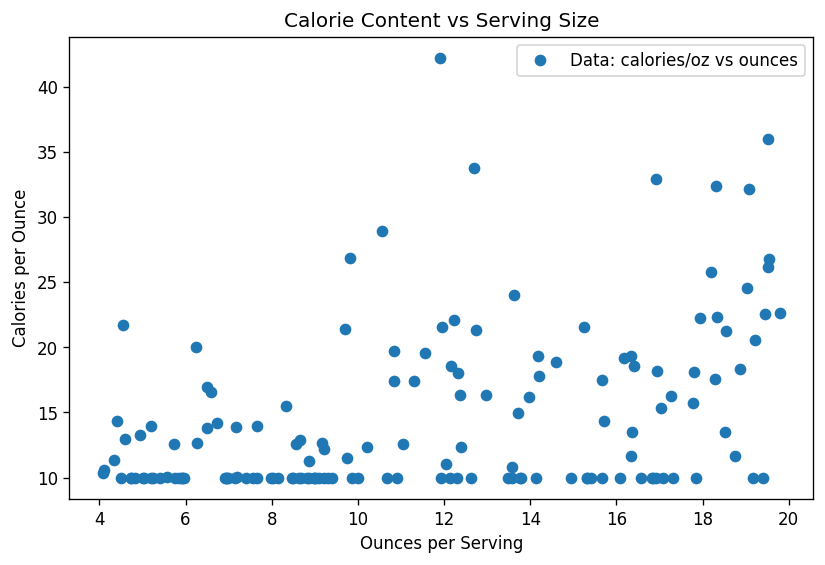

In [ ]:
fig, ax = plt.subplots()
ax.plot(oz, cal_per_ounce, 'o', label='Data: calories/oz vs ounces')
ax.set_title('Calorie Content vs Serving Size')
ax.set_xlabel('Ounces per Serving')
ax.set_ylabel('Calories per Ounce')
ax.legend()
plt.show()

## 5. Define Model Functions

We define:

- Linear:      \(y = a x + b\)  
- Quadratic:   \(y = a x^2 + b x + c\)  
- Exponential: \(y = b e^{a x}\)


In [ ]:
def model_linear(x, a, b):
    """Linear model: y = a*x + b"""
    return a * x + b


def model_quadratic(x, a, b, c):
    """Quadratic model: y = a*x^2 + b*x + c"""
    return a * x**2 + b * x + c


def model_exponential(x, a, b):
    """Exponential model: y = b * e^(a*x)"""
    return b * np.exp(a * x)

## 6. Fit Linear, Quadratic, and Exponential Models (SciPy)

We use `scipy.optimize.curve_fit` to estimate parameters for each model.


In [ ]:
# Linear fit
lin_params, lin_covar = curve_fit(model_linear, oz, cal_per_ounce)
a_lin, b_lin = lin_params

# Quadratic fit
quad_params, quad_covar = curve_fit(model_quadratic, oz, cal_per_ounce)
a_quad, b_quad, c_quad = quad_params

# Exponential fit (provide initial guess for stability)
exp_initial_guess = (0.05, 10.0)
exp_params, exp_covar = curve_fit(model_exponential, oz, cal_per_ounce, p0=exp_initial_guess)
a_exp, b_exp = exp_params

print('Linear parameters (a, b):', lin_params)
print('Quadratic parameters (a, b, c):', quad_params)
print('Exponential parameters (a, b):', exp_params)

Linear parameters (a, b): [0.56353962 8.0981368 ]
Quadratic parameters (a, b, c): [ 0.03168351 -0.19071113 11.87497938]
Exponential parameters (a, b): [0.0393467  9.10821253]


## 7. Plot the Fitted Curves

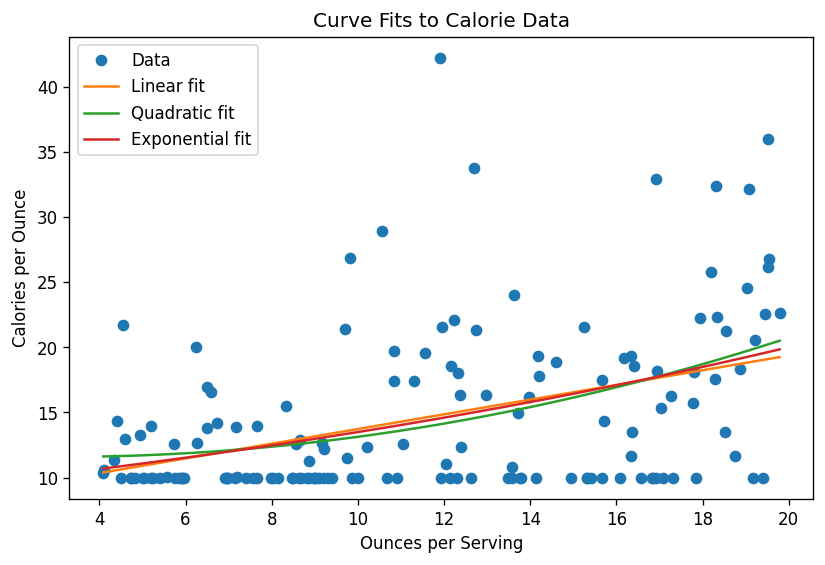

In [ ]:
x_plot = np.linspace(oz.min(), oz.max(), 300)

y_lin = model_linear(x_plot, *lin_params)
y_quad = model_quadratic(x_plot, *quad_params)
y_exp = model_exponential(x_plot, *exp_params)

fig, ax = plt.subplots()
ax.plot(oz, cal_per_ounce, 'o', label='Data')

line_lin,  = ax.plot(x_plot, y_lin, label='Linear fit')
line_quad, = ax.plot(x_plot, y_quad, label='Quadratic fit')
line_exp,  = ax.plot(x_plot, y_exp, label='Exponential fit')

ax.set_title('Curve Fits to Calorie Data')
ax.set_xlabel('Ounces per Serving')
ax.set_ylabel('Calories per Ounce')
ax.legend()
plt.show()

## 8. Linear Fit via Normal Equations

For the linear model \(y = a x + b\), we can write:

\[
A =
\begin{bmatrix}
x_1 & 1 \\
x_2 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix},
\quad
\boldsymbol{\theta} =
\begin{bmatrix}
a \\
b
\end{bmatrix},
\quad
\mathbf{y} =
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}.
\]

The least squares solution is:

\[
\boldsymbol{\theta} = (A^T A)^{-1} A^T \mathbf{y}.
\]


In [ ]:
# Design matrix for linear model
r = oz.shape[0]
A_lin = np.column_stack([oz, np.ones(r)])

theta_lin_la = np.linalg.inv(A_lin.T @ A_lin) @ (A_lin.T @ cal_per_ounce)
a_lin_la, b_lin_la = theta_lin_la

print('Linear (SciPy)     :', lin_params)
print('Linear (Normal Eq.):', theta_lin_la)
print('Close?', np.allclose(lin_params, theta_lin_la))

Linear (SciPy)     : [0.56353962 8.0981368 ]
Linear (Normal Eq.): [0.56353962 8.09813678]
Close? True


## 9. Quadratic Fit via Normal Equations

For the quadratic model \(y = a x^2 + b x + c\), the design matrix is:

\[
B =
\begin{bmatrix}
x_1^2 & x_1 & 1 \\
x_2^2 & x_2 & 1 \\
\vdots & \vdots & \vdots \\
x_n^2 & x_n & 1
\end{bmatrix},
\quad
\boldsymbol{\theta} =
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}.
\]

Again we solve:

\[
\boldsymbol{\theta} = (B^T B)^{-1} B^T \mathbf{y}.
\]


In [ ]:
B_quad = np.column_stack([oz**2, oz, np.ones(r)])

theta_quad_la = np.linalg.inv(B_quad.T @ B_quad) @ (B_quad.T @ cal_per_ounce)
a_quad_la, b_quad_la, c_quad_la = theta_quad_la

print('Quadratic (SciPy)     :', quad_params)
print('Quadratic (Normal Eq.):', theta_quad_la)
print('Close?', np.allclose(quad_params, theta_quad_la))

Quadratic (SciPy)     : [ 0.03168351 -0.19071113 11.87497938]
Quadratic (Normal Eq.): [ 0.0316835  -0.19071093 11.87497834]
Close? True


## 10. Power-Law and Exponential Models via Log Transform

### Power-law model

We assume

\[
y = b x^a.
\]

Taking logs:

\[
\ln y = a \ln x + \ln b,
\]

so we can fit a linear model to \((\ln x, \ln y)\).

### Exponential model

We also consider

\[
y = b e^{a x}.
\]

Taking logs:

\[
\ln y = a x + \ln b,
\]

which is linear in \(x\).


In [ ]:
# Use only positive x and y (true here, but we keep the mask explicit)
mask = (oz > 0) & (cal_per_ounce > 0)
x_pos = oz[mask]
y_pos = cal_per_ounce[mask]

# --- Power law: y = b * x^a ---
X_power = np.column_stack([np.log(x_pos), np.ones_like(x_pos)])
theta_power = np.linalg.inv(X_power.T @ X_power) @ (X_power.T @ np.log(y_pos))
a_power, ln_b_power = theta_power
b_power = np.exp(ln_b_power)

print('Power-law parameters (a, b) for y = b * x^a:')
print('a_power =', a_power)
print('b_power =', b_power)

# --- Exponential: y = b * e^(a x) ---
X_exp_log = np.column_stack([x_pos, np.ones_like(x_pos)])
theta_exp_log = np.linalg.inv(X_exp_log.T @ X_exp_log) @ (X_exp_log.T @ np.log(y_pos))
a_exp_log, ln_b_exp_log = theta_exp_log
b_exp_log = np.exp(ln_b_exp_log)

print('\nExponential (log-fit) parameters (a, b) for y = b * e^(a x):')
print('a_exp_log =', a_exp_log)
print('b_exp_log =', b_exp_log)

Power-law parameters (a, b) for y = b * x^a:
a_power = 0.330574166931424
b_power = 6.235391791902269

Exponential (log-fit) parameters (a, b) for y = b * e^(a x):
a_exp_log = 0.033385442804075086
b_exp_log = 9.226951391589713


## 11. Plot the "Mystery" Curves

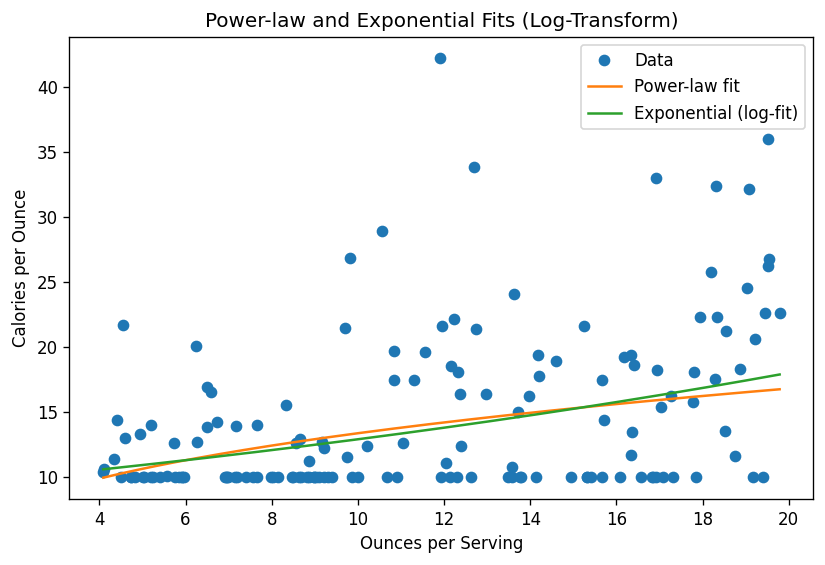

In [ ]:
x_smooth = np.linspace(x_pos.min(), x_pos.max(), 300)

y_power = b_power * x_smooth**a_power
y_exp_log = b_exp_log * np.exp(a_exp_log * x_smooth)

fig, ax = plt.subplots()
ax.plot(oz, cal_per_ounce, 'o', label='Data')

line_power, = ax.plot(x_smooth, y_power, label='Power-law fit')
line_explog, = ax.plot(x_smooth, y_exp_log, label='Exponential (log-fit)')

ax.set_title('Power-law and Exponential Fits (Log-Transform)')
ax.set_xlabel('Ounces per Serving')
ax.set_ylabel('Calories per Ounce')
ax.legend()
plt.show()

**Interpretation:**

- The **power-law** model has the form \(y = b x^a\).  
- The **exponential** log-fit model has the form \(y = b e^{a x}\).


## 12. Optional: Focusing on a Single Model for Clarity

Sometimes showing all models at once is cluttered.  
Below we show a plot that focuses only on the best-behaving model (quadratic, in this synthetic example).


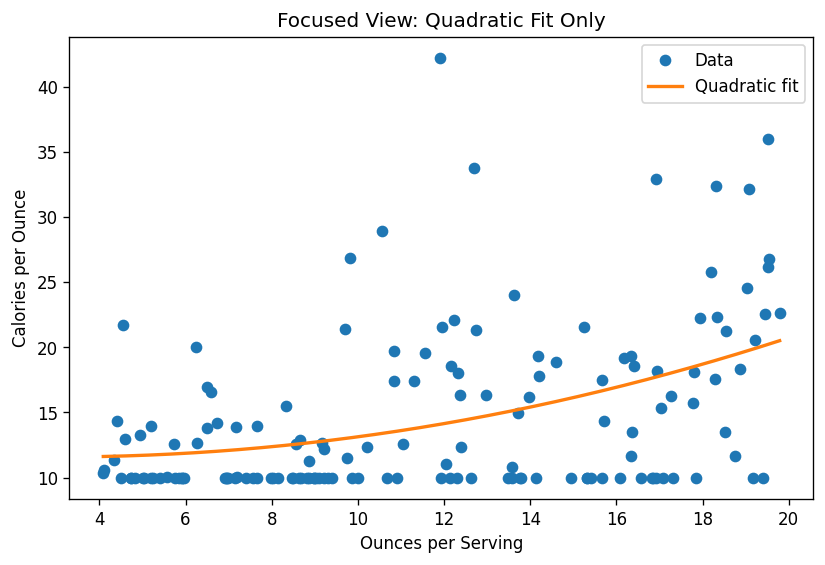

In [ ]:
fig, ax = plt.subplots()
ax.plot(oz, cal_per_ounce, 'o', label='Data')
ax.plot(x_plot, y_quad, label='Quadratic fit', linewidth=2)

ax.set_title('Focused View: Quadratic Fit Only')
ax.set_xlabel('Ounces per Serving')
ax.set_ylabel('Calories per Ounce')
ax.legend()
plt.show()